# Real and Fake Face detection
In this replository is a small application that uses a CNN to predict real or fake face.

Data has been collected from kaggle. For training ~1450 images and with an additional ~300 images for validation.

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt





In [2]:
# Set random seed for reproducibility
tf.random.set_seed(42)

# Dataset

First let's load in the data I've collected from the program. I will use kera's ImageDataGenerator to not only label the data from the directories but also to slightly augment the data with shifts, rotations, zooms, and mirroring. Mirroring will help to ensure that the data are not biased to a particular handedness.

In [3]:
# Data augmentation and normalization
nbatch = 128
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10.,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(
    'dataset/training',
    target_size=(128, 128),
    batch_size=nbatch,
    class_mode='binary'
)

test_set = test_datagen.flow_from_directory(
    'dataset/test',
    target_size=(128, 128),
    batch_size=nbatch,
    class_mode='binary'
)

Found 1437 images belonging to 2 classes.


Found 604 images belonging to 2 classes.


Text(0.5, 0, 'Class')

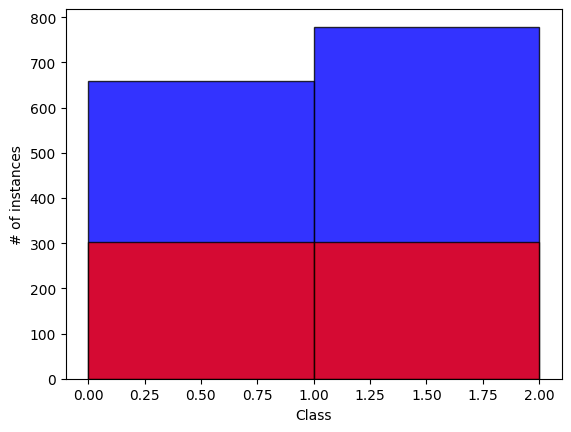

In [4]:
# Plot histograms
h1 = plt.hist(training_set.classes, bins=range(0, 3), alpha=0.8, color='blue', edgecolor='black')
h2 = plt.hist(test_set.classes, bins=range(0, 3), alpha=0.8, color='red', edgecolor='black')
plt.ylabel('# of instances')
plt.xlabel('Class')


(128, 128, 128, 3) (128,)


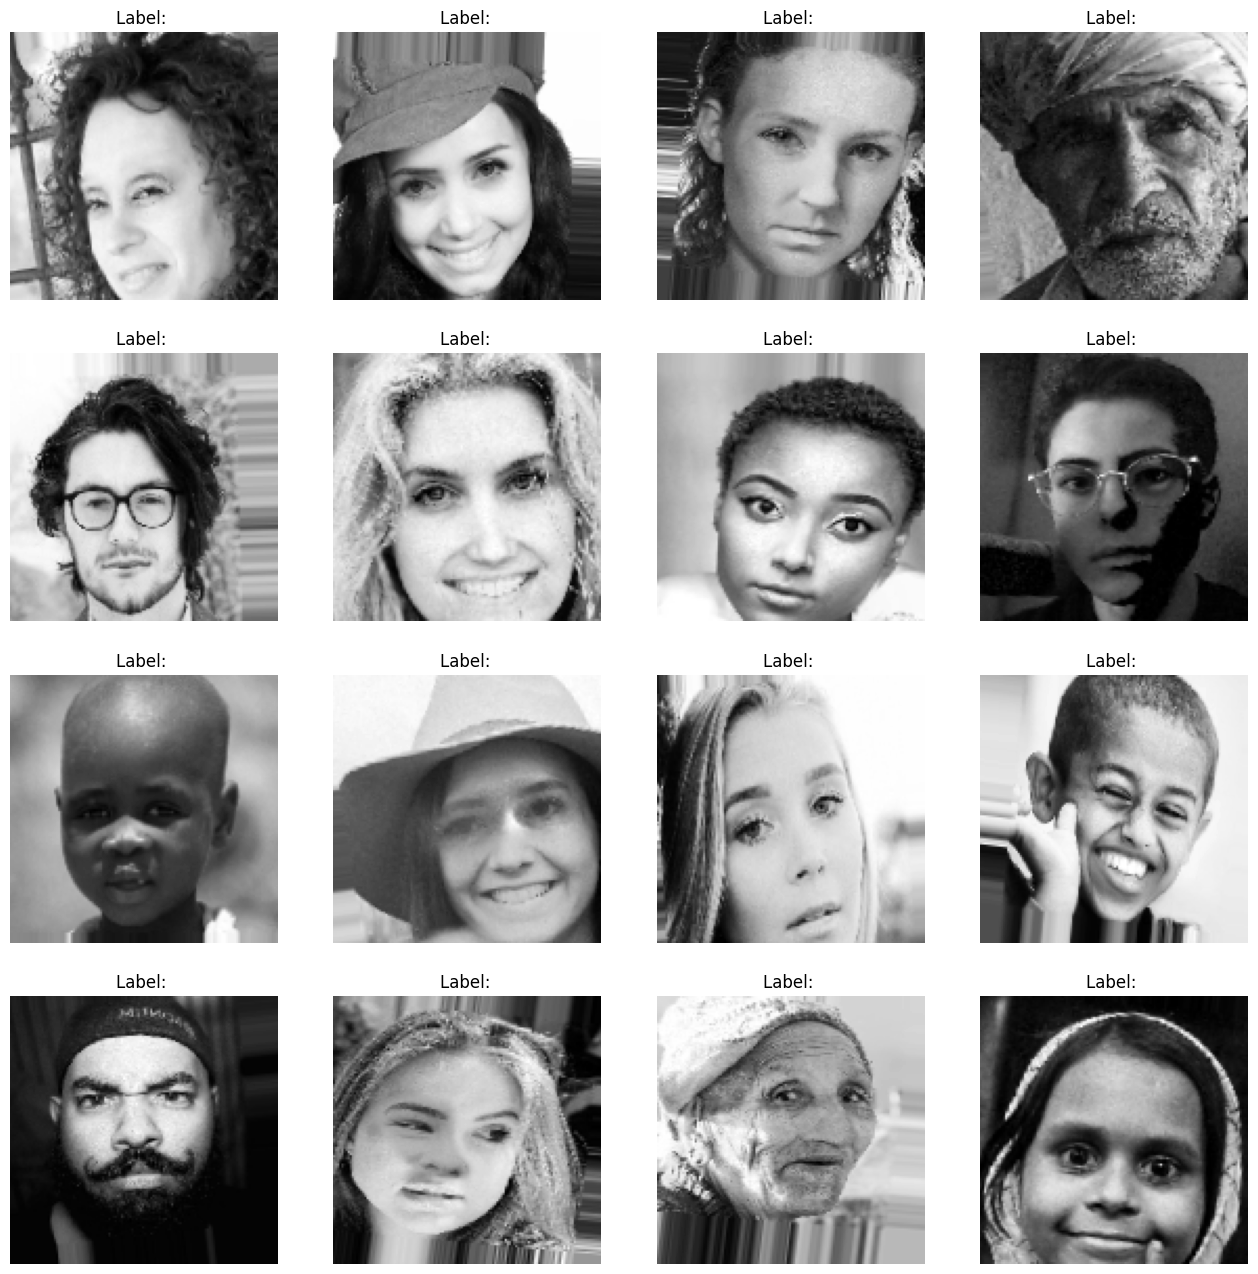

In [5]:
# Display sample images
for X, y in training_set:
    print(X.shape, y.shape)
    plt.figure(figsize=(16, 16))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.axis('off')
        plt.title('Label: ')
        img = np.uint8(255 * X[i, :, :, 0])
        plt.imshow(img, cmap='gray')
    break


# Convolutional Neural Net
The data looks resonable so now I will define a CNN model to train and use within our application.

In [6]:
# Build the model
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(activation="relu", units=256))

model.add(Dense(activation="sigmoid", units=1))

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)      

##### Compile the model

In [7]:
model.compile(optimizer='adam', loss=tf.compat.v1.losses.sparse_softmax_cross_entropy, metrics=['accuracy'])

# Training
Finally we will train our model using some keras helper functions. We are not doing any hyper-parameter optimization so we will not define a separate testing and validation set. We can however evaluate our model further in real time within the application.

In [8]:
# Define callbacks
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=10),
    ModelCheckpoint(filepath='model_checkpoint.hdf5', monitor='val_loss', save_best_only=True, mode='max'),
]

In [9]:
# Train the model
history = model.fit(
    training_set,
    steps_per_epoch=len(training_set),
    epochs=10,
    validation_data=test_set,
    validation_steps=len(test_set),
    callbacks=callbacks_list
)

Epoch 1/10


TypeError: in user code:

    File "d:\Python\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "d:\Python\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\Python\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "d:\Python\Lib\site-packages\keras\src\engine\training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "d:\Python\Lib\site-packages\keras\src\engine\training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "d:\Python\Lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "d:\Python\Lib\site-packages\keras\src\losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "d:\Python\Lib\site-packages\keras\src\losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)

    TypeError: Value passed to parameter 'labels' has DataType float32 not in list of allowed values: int32, int64


In [33]:
training_set.class_indices

{'fake': 0, 'real': 1}

KeyError: 'acc'

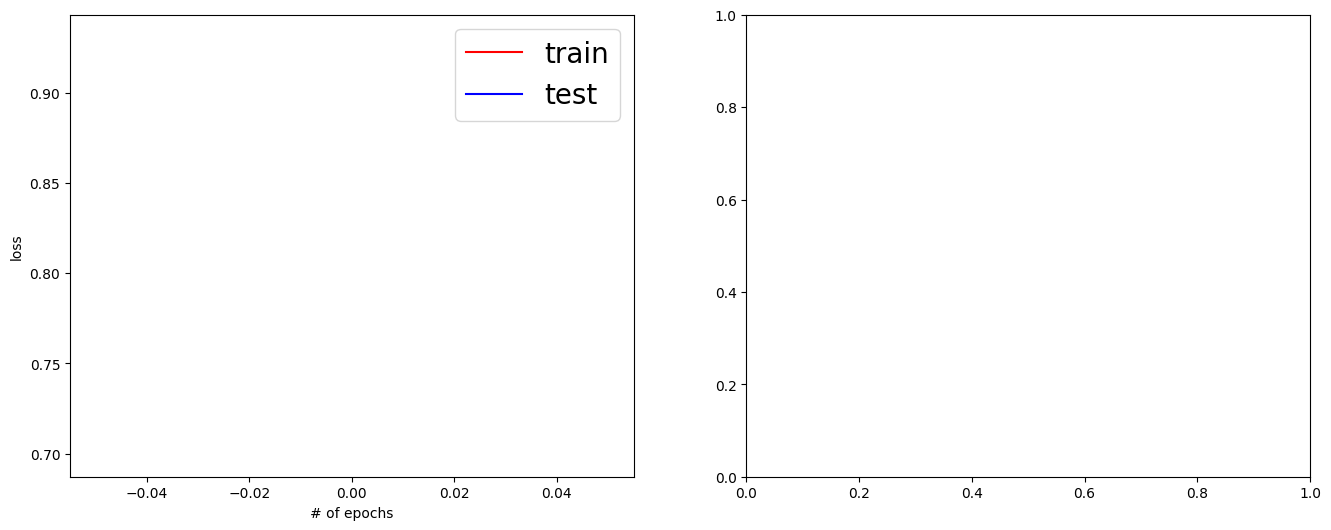

In [34]:
plt.figure(figsize=(16, 6))

# Plot loss
plt.subplot(1, 2, 1)
nepochs = len(history.history['loss'])
plt.plot(range(nepochs), history.history['loss'], 'r-', label='train')
plt.plot(range(nepochs), history.history['val_loss'], 'b-', label='test')
plt.legend(prop={'size': 20})
plt.ylabel('loss')
plt.xlabel('# of epochs')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(nepochs), history.history['accuracy'], 'r-', label='train')
plt.plot(range(nepochs), history.history['val_accuracy'], 'b-', label='test')
plt.legend(prop={'size': 20})
plt.ylabel('accuracy')
plt.xlabel('# of epochs')

plt.show()


# Prediction
Now the model is trained so I used some real images and edited that image so that we can analysis model is working correcly or not.

In [35]:
def ImagePrediction(loc):
    test_image = image.load_img(loc, target_size = (128,128))
    plt.axis('off')
    plt.imshow(test_image)
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis =0)
    result = model.predict(test_image)
    if result[0][0] == 1:
        predictions = 'Real'
    else:
        predictions = 'Fake'
    print('Prediction: ',predictions)

In [36]:
img = input("Enter Location of Image to predict: ")
test_image_1 = ImagePrediction(img)

Enter Location of Image to predict: dataset/face_pred/check2.jpg
Prediction:  Fake


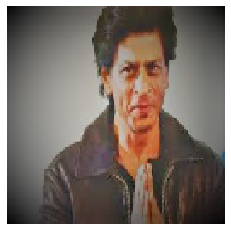

In [ ]:
img = input("Enter Location of Image to predict: ")
test_image_2 = ImagePrediction(img)

Enter Location of Image to predict: dataset/face_pred/check3.jpg
Prediction:  Real


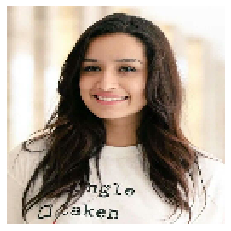

In [ ]:
img = input("Enter Location of Image to predict: ")
test_image_3 = ImagePrediction(img)

Enter Location of Image to predict: dataset/face_pred/check4.jpg
Prediction:  Real


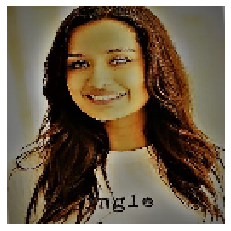

In [ ]:
img = input("Enter Location of Image to predict: ")
test_image_3 = ImagePrediction(img)

## Result
3 out of 4 images is predicted correctly althrough model is not trained well by incereasing epoc near about 40 will probably make this model perfectly trained but that will require 5-6hr for training.